# Kidney Neural Network - Improved Model

This notebook implements an improved version of the Kidney Neural Network model with the following enhancements:
1. **Data Leakage Fix**: Removed `kidney_acr_mg_g` from input features.
2. **Architecture**: Deeper network (128->64->32), Batch Normalization, and Dropout.
3. **Training**: Mini-batch training (DataLoader), Early Stopping, and Learning Rate Scheduler.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Data Loading and Preprocessing

In [ ]:
def load_and_process_data(filepath):
    print("Loading data...")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")
        
    df = pd.read_csv(filepath)
    
    # Define feature columns (first 35 columns as per notebook)
    feature_cols = df.columns[:35].tolist()
    target_col = 'kidney_acr_mg_g'  # Updated to new standardized column name
    data_type_col = 'data_type'
    
    # Remove target from features if present to prevent data leakage
    if target_col in feature_cols:
        print(f"Removing target '{target_col}' from features.")
        feature_cols.remove(target_col)
    
    # Combine features and target for cleaning
    # Ensure no duplicate columns in selection
    cols_to_select = list(set(feature_cols + [target_col, data_type_col]))
    data = df[cols_to_select].copy()
    
    # Drop rows with missing target values
    original_len = len(data)
    data.dropna(subset=[target_col], inplace=True)
    print(f"Dropped {original_len - len(data)} rows with missing target values.")
    
    # Separate features and data_type
    X_data = data[feature_cols]
    data_types = data[data_type_col]
    y_data = data[target_col].values.reshape(-1, 1) # Reshape to 2D array
    
    # Create Mask Matrix
    mask_matrix = X_data.notna().astype(np.float32).values
    
    # Impute NaN values with 0
    X_imputed = X_data.fillna(0).values
    
    # Split into train and test
    train_mask = (data_types == 'training').values
    test_mask = (data_types == 'testing').values
    
    X_train = X_imputed[train_mask]
    y_train = y_data[train_mask]
    Mask_train = mask_matrix[train_mask]
    
    X_test = X_imputed[test_mask]
    y_test = y_data[test_mask]
    Mask_test = mask_matrix[test_mask]
    
    print(f"Training Data Shape: {X_train_tensor.shape if 'X_train_tensor' in locals() else X_train.shape}")
    
    # Convert to Tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    Mask_train_tensor = torch.tensor(Mask_train, dtype=torch.float32)
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    Mask_test_tensor = torch.tensor(Mask_test, dtype=torch.float32)
    
    return (X_train_tensor, y_train_tensor, Mask_train_tensor), (X_test_tensor, y_test_tensor, Mask_test_tensor)

# Load Data
try:
    (X_train, y_train, Mask_train), (X_test, y_test, Mask_test) = load_and_process_data('datasets/combined_data.csv')
except Exception as e:
    import traceback
    traceback.print_exc()

Loading data...
Removing target 'ACR_Log' from features.
Dropped 6320 rows with missing target values.
Training Data Shape: (35712, 34)


## 2. Model Definition

In [3]:
class ImprovedRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ImprovedRegressionModel, self).__init__()
        
        # Deeper architecture with Batch Normalization and Dropout
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        return self.fc4(x)

## 3. Training Loop

In [4]:
# Hyperparameters
INPUT_SIZE = X_train.shape[1]
OUTPUT_SIZE = 1
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 200
PATIENCE = 15 # Early stopping patience

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train, Mask_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model, Loss, Optimizer
model = ImprovedRegressionModel(INPUT_SIZE, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("\nStarting Training...")

best_loss = float('inf')
patience_counter = 0
train_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    
    for batch_X, batch_y, batch_mask in train_loader:
        optimizer.zero_grad()
        
        # Apply mask
        masked_inputs = batch_X * batch_mask
        
        outputs = model(masked_inputs)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation (using test set for early stopping monitoring here)
    model.eval()
    with torch.no_grad():
        masked_test_inputs = X_test * Mask_test
        test_outputs = model(masked_test_inputs)
        val_loss = criterion(test_outputs, y_test).item()
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
    # Early Stopping Check
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        # Save best model state
        torch.save(model.state_dict(), 'best_kidney_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
print("Training finished.")


Starting Training...
Epoch [10/200], Train Loss: 0.9062, Val Loss: 0.8861
Epoch [20/200], Train Loss: 0.8456, Val Loss: 0.8320
Epoch [30/200], Train Loss: 0.8140, Val Loss: 0.8439
Epoch [40/200], Train Loss: 0.7982, Val Loss: 0.8266
Epoch [50/200], Train Loss: 0.7902, Val Loss: 0.8296
Epoch [60/200], Train Loss: 0.7795, Val Loss: 0.8161
Epoch [70/200], Train Loss: 0.7753, Val Loss: 0.8102
Epoch [80/200], Train Loss: 0.7783, Val Loss: 0.8211
Epoch [90/200], Train Loss: 0.7701, Val Loss: 0.8113
Early stopping triggered at epoch 90
Training finished.


## 4. Evaluation


Final Test MSE: 0.8069
Final Test RMSE: 0.8983


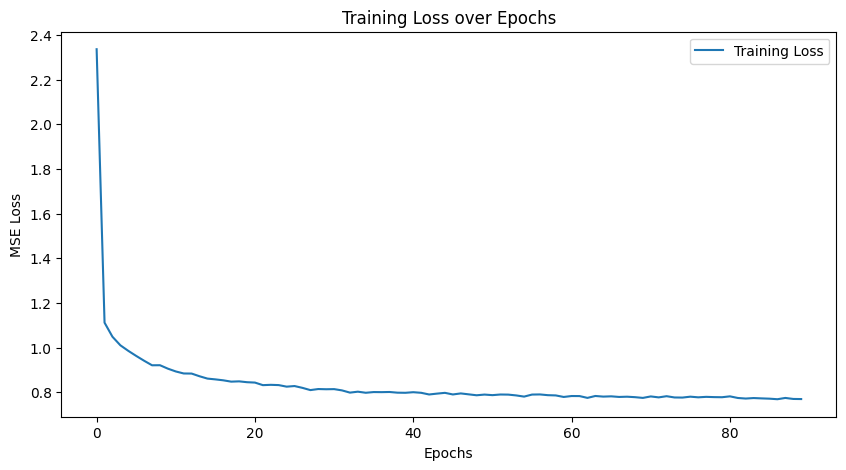

In [5]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_kidney_model.pth'))
model.eval()

with torch.no_grad():
    masked_test_inputs = X_test * Mask_test
    predictions = model(masked_test_inputs)
    final_mse = criterion(predictions, y_test).item()
    final_rmse = np.sqrt(final_mse)
    
print(f'\nFinal Test MSE: {final_mse:.4f}')
print(f'Final Test RMSE: {final_rmse:.4f}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()